Let's import everything necessary to get ready for classification:

In [8]:
%pylab inline
import pandas as pd
import numpy as np
from sklearn import model_selection
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, roc_auc_score
from sklearn.metrics import roc_curve, precision_recall_curve
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
import time

train = pd.read_csv('/Users/daniiltekunov/Desktop/mobile-price-classification/train.csv')

y = train.price_range

X = train.drop('price_range', axis=1)

divide_seed = np.random.randint(1, 100)

X_train, X_test, y_train, y_test = model_selection.train_test_split(
    X, y, test_size=0.3, random_state=divide_seed)

scaler = StandardScaler()

scaler.fit(X_train)
X_train = scaler.transform(X_train)

scaler.fit(X_test)
X_test = scaler.transform(X_test)

print(len(X_train))
print(len(X_test))
print(len(y_train))
print(len(y_test))

Populating the interactive namespace from numpy and matplotlib
1400
600
1400
600


Let's start with a linear regression:

In [9]:
lr = LinearRegression()

lr.fit(X_train, y_train)

prediction_lr = lr.predict(X_train)

print("Test result:", lr.score(X_test, y_test))

print("Train result:", lr.score(X_train, y_train))

Test result: 0.9199213823065907
Train result: 0.9166628312925383


Now, let's continue with kNN:

In [12]:
list_of_predictions_knn = list()
list_of_test_results_knn = list()
list_of_train_results_knn = list()

for i in range(1, 101):
    knn = KNeighborsClassifier(n_neighbors=i)
    knn.fit(X_train, y_train)
    list_of_predictions_knn.append(knn.predict(X_train))
    list_of_test_results_knn.append(knn.score(X_test, y_test))
    list_of_train_results_knn.append(knn.score(X_train, y_train))
    if i % 20 == 0:
        print("Predicted with ", i, " neighbours")

Predicted with  20  neighbours


Predicted with  40  neighbours


Predicted with  60  neighbours


Predicted with  80  neighbours


Predicted with  100  neighbours


Max test result:  0.65  takes  74  trees


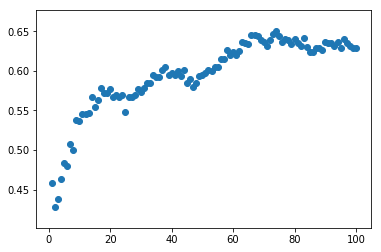

In [13]:
print("Max test result: ", max(list_of_test_results_knn), 
      " takes ", (list_of_test_results_knn.index(max(list_of_test_results_knn))+1), " trees")

plt.scatter(x=list((range(1, 101))), y=list_of_test_results_knn)

Next classifier we'll try to use is Logistic Regression:

In [19]:
logistic_model = LogisticRegression()

logistic_model.fit(X_train, y_train)

prediction = logistic_model.predict(X_test)

#print("Test result:", logistic_model.score(X_test, y_test))

print("Train result:", logistic_model.score(X_train, y_train))

print("Accuracy:", accuracy_score(y_test, prediction))

#print("AUC-ROC:", roc_auc_score(y_test, prediction))

print("######################################################")
logistic_model_proba = LogisticRegression()

logistic_model_proba.fit(X_train, y_train)

prediction_proba = logistic_model.predict_proba(X_test)

Train result: 0.8464285714285714
Accuracy: 0.795
######################################################


Next step we'll take is DecisionTree model:

In [22]:
decision_tree = DecisionTreeClassifier(random_state=divide_seed)

decision_tree.fit(X_train, y_train)

prediction_tree = decision_tree.predict(X_test)

print("Test result (accuracy):", decision_tree.score(X_test, y_test))

print("Accuracy:", accuracy_score(y_test, prediction_tree))

print("######################################################")
decision_tree_proba = DecisionTreeClassifier(random_state=divide_seed)

decision_tree_proba.fit(X_train, y_train)

prediction_tree_proba = decision_tree_proba.predict_proba(X_test)[:, 1]

Test result (accuracy): 0.8516666666666667
Accuracy: 0.8516666666666667
######################################################


This accuracy is not enough to accept this decision tree model, so, let's try to use bagging to try to improve it.

In [33]:
bagging = BaggingClassifier(base_estimator=DecisionTreeClassifier(random_state=divide_seed), n_estimators=100)

bagging.fit(X_train, y_train)

prediction_bagging = bagging.predict(X_test)

print("######################################################")
bagging_proba = BaggingClassifier(base_estimator=DecisionTreeClassifier(random_state=divide_seed), n_estimators=100)

bagging_proba.fit(X_train, y_train)

prediction_bagging_proba = bagging_proba.predict_proba(X_test)[:, 1]

print("Accuracy:", accuracy_score(y_test, prediction_bagging_proba > 0.5))

######################################################


Accuracy: 0.43333333333333335


In [35]:
new_predicted_tree = 0
new_predicted_tree_proba = np.zeros(X_test.shape[0])


for k in range(0, 100):
    i_new = np.random.randint(0, X_train.shape[0], int(2000*0.7))
    tree_class = DecisionTreeClassifier()
    
    tree_class.fit(X_train[i_new], array(y_train)[i_new])
    
    new_predicted_tree_proba += tree_class.predict_proba(X_test)[:, 1]
    
    new_predicted_tree += tree_class.predict(X_test)
    new_predicted_tree = np.divide(new_predicted_tree, 100).astype('int8')
    
new_predicted_tree_proba = new_predicted_tree_proba / 100
    

print("Accuracy:", accuracy_score(y_test, new_predicted_tree_proba > 0.5))

Accuracy: 0.43666666666666665


Still bad, need to try random forest.

In [38]:
test_forest_results = list()
train_forest_results = list()
accuracy_forest_results = list()
auc_roc_forest_results = list()
time_list = list()

accuracy_forest_results_proba = list()
auc_roc_forest_results_proba = list()

start = time.time()
cur_time = start

for j in range(10, 1010, 10):
    
    decision_forest = RandomForestClassifier(random_state=divide_seed, n_estimators=j)
    decision_forest_proba = RandomForestClassifier(random_state=divide_seed, n_estimators=j)

    decision_forest.fit(X_train, y_train)
    
    decision_forest_proba.fit(X_train, y_train)

    prediction_forest = decision_forest.predict(X_test)
    
    prediction_forest_pr = decision_forest_proba.predict_proba(X_test)[:, 1]

    test_forest_results.append(decision_forest.score(X_test, y_test))

    train_forest_results.append(decision_forest.score(X_train, y_train))

    accuracy_forest_results.append(accuracy_score(y_test, prediction_forest))
    
    accuracy_forest_results_proba.append(accuracy_score(y_test, prediction_forest_pr > 0.5))

    if j % 50 == 0:
        cur_time = time.time() - cur_time
        if j % 100 != 0:
            time_list.append(cur_time)
            print('Number of trees:', j)
            print("Prediction completed by", j/10, "%")
            print("Took ", cur_time, " seconds")
            print("--------------------")
print("Prediction completed by 100%")
finish = time.time() - start

print("Prediction took ", finish, " seconds")

Number of trees: 50
Prediction completed by 5.0 %
Took  1.1244707107543945  seconds
--------------------


Number of trees: 150
Prediction completed by 15.0 %
Took  6.452134609222412  seconds
--------------------


Number of trees: 250
Prediction completed by 25.0 %
Took  16.21289873123169  seconds
--------------------


Number of trees: 350
Prediction completed by 35.0 %
Took  27.84582281112671  seconds
--------------------


Number of trees: 450
Prediction completed by 45.0 %
Took  43.706652879714966  seconds
--------------------


Number of trees: 550
Prediction completed by 55.0 %
Took  63.87005567550659  seconds
--------------------


Number of trees: 650
Prediction completed by 65.0 %
Took  86.38479399681091  seconds
--------------------


Number of trees: 750
Prediction completed by 75.0 %
Took  113.22488784790039  seconds
--------------------


Number of trees: 850
Prediction completed by 85.0 %
Took  142.7036998271942  seconds
--------------------


Number of trees: 950
Prediction completed by 95.0 %
Took  177.45029473304749  seconds
--------------------


Prediction completed by 100%
Prediction took  374.46624064445496  seconds


Max test result:  0.885  takes  250  trees
Max accuracy result:  0.885  takes  250  trees
Max accuracy result with proba:  0.385  takes  250  trees


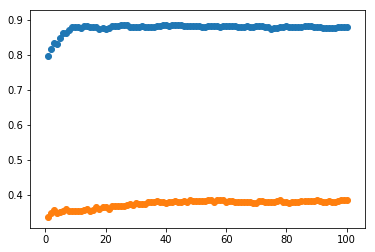

Time taken via number of trees:


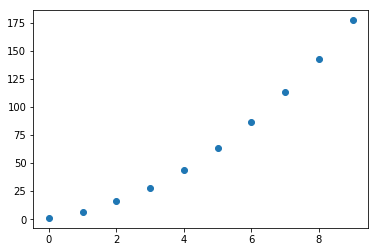

In [42]:
print("Max test result: ", max(test_forest_results), " takes ", (test_forest_results.index(max(test_forest_results))+1)*10, " trees")

print("Max accuracy result: ", max(accuracy_forest_results), " takes ", (accuracy_forest_results.index(max(accuracy_forest_results))+1)*10, " trees")

print("Max accuracy result with proba: ", max(accuracy_forest_results_proba), " takes ", (accuracy_forest_results.index(max(accuracy_forest_results))+1)*10, " trees")

plt.scatter(x=list((range(1, 101))), y=accuracy_forest_results)

plt.scatter(x=list((range(1, 101))), y=accuracy_forest_results_proba)
plt.show()

print("Time taken via number of trees:")
plt.scatter(x=list(range(0, 10)), y=time_list)
plt.show()

Finally, let's take a look at which features were most important in our model:

[0.07303068 0.00705218 0.02845247 0.00692373 0.02563393 0.00716181
 0.03797567 0.02550083 0.04049928 0.02328117 0.03035683 0.05979071
 0.06074744 0.46498961 0.02812643 0.02933613 0.03107064 0.00580641
 0.00728066 0.00698339]


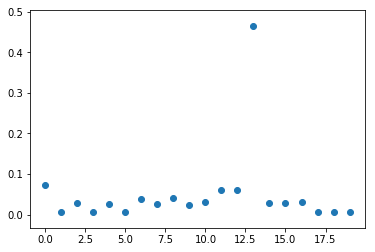

In [43]:
importances = list(decision_forest.feature_importances_)

number = list(range(0, 20, 1))

print(decision_forest.feature_importances_)

plt.scatter(x=number, y=importances)

As we can see, 14th feature is much more important than others, so it dominates and that is whe linear regression is so good in this case.